# The Battle of Neighborhoods

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Introduction</a>
    

2. <a href="#item2">Data Description</a>
    

3. <a href="#item3">Methodology</a>
    

4. <a href="#item3">Results</a>   
    
    
5. <a href="#item3">Discussion</a>
    
    
6. <a href="#item3">Conclusion</a>
</font>
</div>

## 1. Introduction

### 1.1 Background

In this project we are going to explore the neighborhoods of the most popular cities, New York and Toronto. They are the international centers of business, finance, arts, culture, and are recognized as the most multicultural cosmopolitans in the world.They are diverse in many ways. One interesting idea would be to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. 

### 1.2 Problem Description

Let me explain the idea of this project through a scenario. Say you live in the New York City of USA. You love your neighborhood, mainly because of all the great amenities and other types of venues that exist in the neighborhood, such as gourmet fast food joints, pharmacies, parks, and so on. Now say you receive a job offer from a great company which is in Toronto, Canada with great career prospects. However, given the far distance from your current place you unfortunately must move if you decide to accept the offer.

Wouldn't it be great if you are able to determine a neighborhood that are the same as your current neighborhood, and if not perhaps a similar neighborhoods that are at least closer to your new job?

### 1.3 Target Audience

We will study and analyze the neighborhoods of both the cities and group them into similar clusters and, analyze those clusters to gather meaningful information. That information can be used to find out neighborhoods that are same as your current neighborhood or at least similar.

The information provided by this project would be useful for people who are interested in relocating to different places and are interested in finding new neighborhoods that are highly similar to their existing neighborhood.

## 2. Data Description

The NYC neighborhood data exists for free on the web. Here is the link to the dataset:https://geo.nyu.edu/catalog/nyu_2451_34572, I downloaded the files and placed it on the server. For Toronto neighborhood data,a Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, exists that has all the information we needed to explore. We will scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe.

Note: There are different website scraping libraries and packages in Python. We can simply use pandas to read the table into a pandas dataframe. Another way, for more complicated cases of web scraping is using the BeautifulSoup package. Here is the package's main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/

## 3. Methodology

For this problem, we will get the services of Foursquare API to explore the data of two cities, in terms of their neighborhoods. The data include the information about the places around each neighborhood like restaurants, hotels, coffee shops, parks, theaters, art galleries, museums and many more. In order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. Here is a link to a csv file that has the geographical coordinates of each postal code of toronto: http://cocl.us/Geospatial_data.
We will use the machine learning technique, “Clustering” to segment the neighborhoods with similar objects on the basis of each neighborhood data. Finally, you will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.

### Import all the required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.0               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
# obtain New York neighborhood data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
nyneighborhoods = newyork_data['features']

# define the dataframe with four columns: City, Borough, Neighborhood, Latitude, Longitude
column_names = ['City','Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
ny_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyneighborhoods:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'City': 'New York',
                                          'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
ny_neighborhoods.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,New York,Bronx,Wakefield,40.894705,-73.847201
1,New York,Bronx,Co-op City,40.874294,-73.829939
2,New York,Bronx,Eastchester,40.887556,-73.827806
3,New York,Bronx,Fieldston,40.895437,-73.905643
4,New York,Bronx,Riverdale,40.890834,-73.912585


In [6]:
#Define a function to plot the city map with different neighborhood labels based on Borough

def citymap(cityname,countryname,dataframe):
    
    # create map
    address = cityname + ',' + countryname

    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    my_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Borough
    borough_name = dataframe['Borough'].unique().tolist()
    colnum = dataframe['Borough'].unique().size
    x = np.arange(colnum)
    ys = [i+x+(i*x)**2 for i in range(colnum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map

    for lat, lon, neighborhood, borough in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Neighborhood'], dataframe['Borough']):
        cluster = borough_name.index(borough)
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(my_map)
       
    
    return my_map

In [7]:
citymap('New York','USA',ny_neighborhoods)

In [8]:
# obtain Toronto neighborhood data
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
wikipage = requests.get(url)
wikipage.text[:100]

#Create a new pd DataFrame
toronto = pd.DataFrame()

#use beautifulsoup to read the wikipage
soup = BeautifulSoup(wikipage.text, 'lxml')
wikitable = soup.find_all('table')[0] 

row_marker = 0

for row in wikitable.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    for column in columns:
        toronto.loc[row_marker,column_marker] = column.get_text()
        column_marker += 1
    row_marker += 1

#rename column names
toronto.rename(columns={0:'PostalCode',1:'Borough',2:'Neighborhood'}, inplace=True)

#drop the boroughs that has 'not assigned' value 
toronto=toronto[~toronto.Borough.str.contains("Not assigned")]
toronto=toronto.reset_index(drop=True)

#create a new dataframe toronto_neighbor to find all neighborhoods with the location information
toronto_neighborhoods= pd.DataFrame(columns = ['City','Borough','Neighborhood'])

for i in range(toronto.shape[0]):
    borough = toronto.loc[i,'Borough'][:-1] #delete the last character \n
    postalcode = toronto.loc[i,'PostalCode']
    neighborhood = toronto.loc[i,'Neighborhood'][:-1] #delete the last character \n
    
    #if the neighborhood name is not assigned, than the neighorhood name is same as borough
    if neighborhood == 'Not assigned':
        neighborhood = borough
    
    #find the location data, ignore the neighborhoods that are unable to be located by Nominatim
    geolocator = Nominatim(user_agent="mycapstoneproject")
    location = geolocator.geocode("{},{},Toronto,Ontario,Canada".format(neighborhood,borough))
    
    #try one more searching
    if location is None: 
        location = geolocator.geocode("{},Toronto,Ontario,Canada".format(neighborhood))
        
    else:
        toronto_neighborhoods = toronto_neighborhoods.append({'City': 'Toronto',
                                                'Borough': borough,
                                                'Neighborhood': neighborhood,
                                                'Latitude': location.latitude,
                                                'Longitude': location.longitude
                                               }, ignore_index=True)

toronto_neighborhoods.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.758800,-79.320197
1,Toronto,North York,Victoria Village,43.732658,-79.311189
2,Toronto,Etobicoke,Islington Avenue,43.622575,-79.514215
3,Toronto,Scarborough,Malvern / Rouge,43.809196,-79.221701
4,Toronto,North York,Don Mills,43.775347,-79.345944


In [9]:
citymap('Toronto','Canada',toronto_neighborhoods)

In [10]:
#shape of toronto neighborhood
toronto_neighborhoods.shape

(47, 5)

In [11]:
#shape of ny neighborhood
ny_neighborhoods.shape

(306, 5)

In [12]:
#save the data to a csv
ny_neighborhoods.to_csv('ny_neighborhoods.csv', sep='\t')
toronto_neighborhoods.to_csv('toronto_neighborhoods.csv', sep='\t')

In [13]:
#Use Foursquare to expore the neighborhoods
#My Foursquare Credentials 
CLIENT_ID = 'S1KVEF2AKPAYLU1ETMETRFO3R0FWOUJXWWGQ55TILVFOAOLY' 
CLIENT_SECRET = 'G1EAHHBTQRSOP4JVOIQBM4QV452XF5JZBLV04MV0CSPKJLAF' 
VERSION = '20180605' # Foursquare API version
LIMIT = 50 

# define a function to expore each city in radius of 1000 meters
def getNearbyVenues(nborhood, radius=1000):
    
    venues=pd.DataFrame(columns=['City','Borough','Neighborhood','VenueName','VenueCategory'])
    for city, borough, neighborhood, lat, lng in zip(nborhood['City'], nborhood['Borough'], nborhood['Neighborhood'], nborhood['Latitude'], nborhood['Longitude']):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
       # return only relevant information for each nearby venue
        if results is not None:
            for v in results:
                venues = venues.append({'City':city, 'Borough':borough, 'Neighborhood': neighborhood, 
                           'VenueName': v['venue']['name'], 
                           'VenueCategory': v['venue']['categories'][0]['name']},ignore_index=True)

   
    
    return(venues)

In [14]:
# obtain the nearby venues of each neighborhood in New York
ny_venues = getNearbyVenues(ny_neighborhoods)
ny_venues.head()

,City,Borough,Neighborhood,VenueName,VenueCategory
0,New York,Bronx,Wakefield,Lollipops Gelato,Dessert Shop
1,New York,Bronx,Wakefield,Ripe Kitchen & Bar,Caribbean Restaurant
2,New York,Bronx,Wakefield,Ali's Roti Shop,Caribbean Restaurant
3,New York,Bronx,Wakefield,Carvel Ice Cream,Ice Cream Shop
4,New York,Bronx,Wakefield,Jimbo's,Burger Joint


In [15]:
#save the data
ny_venues.to_csv('ny_venues.csv', sep='\t')
ny_venues.shape

(13365, 5)

In [16]:
# obtain the nearby venues of each neighborhood in toronto
toronto_venues = getNearbyVenues(toronto_neighborhoods)
toronto_venues.head()

,City,Borough,Neighborhood,VenueName,VenueCategory
0,Toronto,North York,Parkwoods,Allwyn's Bakery,Caribbean Restaurant
1,Toronto,North York,Parkwoods,LCBO,Liquor Store
2,Toronto,North York,Parkwoods,Tim Hortons,Café
3,Toronto,North York,Parkwoods,Dollarama,Discount Store
4,Toronto,North York,Parkwoods,A&W,Fast Food Restaurant


In [17]:
# save the data
toronto_venues.to_csv('toronto_venues.csv', sep='\t')
toronto_venues.shape

(1590, 5)

In [18]:
#combine the two neighborhood venues 
allvenues =  pd.concat([ny_venues,toronto_venues])
allvenues = allvenues.rename(columns={'Neighborhood': 'NeighborhoodName'})
allvenues.shape

(14955, 5)

In [19]:
#check the new all venues df
allvenues.head()

,City,Borough,NeighborhoodName,VenueName,VenueCategory
0,New York,Bronx,Wakefield,Lollipops Gelato,Dessert Shop
1,New York,Bronx,Wakefield,Ripe Kitchen & Bar,Caribbean Restaurant
2,New York,Bronx,Wakefield,Ali's Roti Shop,Caribbean Restaurant
3,New York,Bronx,Wakefield,Carvel Ice Cream,Ice Cream Shop
4,New York,Bronx,Wakefield,Jimbo's,Burger Joint


In [20]:
#combine neighborhoods
allneighborhoods =  pd.concat([ny_neighborhoods,toronto_neighborhoods])
allneighborhoods = allneighborhoods.rename(columns={'Neighborhood': 'NeighborhoodName'})
allneighborhoods.shape

(353, 5)

In [21]:
allneighborhoods.head()

,City,Borough,NeighborhoodName,Latitude,Longitude
0,New York,Bronx,Wakefield,40.894705,-73.847201
1,New York,Bronx,Co-op City,40.874294,-73.829939
2,New York,Bronx,Eastchester,40.887556,-73.827806
3,New York,Bronx,Fieldston,40.895437,-73.905643
4,New York,Bronx,Riverdale,40.890834,-73.912585


Group the venues depends on their categories and calculate the total number of venues of each category

In [22]:
# get dummies
allvenues_onehot_encod = pd.get_dummies(allvenues, columns = ['VenueCategory'], prefix="", prefix_sep="")
allvenues_onehot_encod = allvenues_onehot_encod.drop('VenueName',axis = 1)

In [23]:
allvenues_onehot_encod.shape

(14955, 456)

In [24]:
# all venue category names
allvenues_onehot_encod.columns.values

array(['City', 'Borough', 'NeighborhoodName', 'Accessories Store',
       'Adult Boutique', 'Afghan Restaurant', 'African Restaurant',
       'Airport Lounge', 'Airport Service', 'American Restaurant',
       'Animal Shelter', 'Antique Shop', 'Aquarium', 'Arcade',
       'Arepa Restaurant', 'Argentinian Restaurant', 'Art Gallery',
       'Art Museum', 'Arts & Crafts Store', 'Arts & Entertainment',
       'Asian Restaurant', 'Athletics & Sports', 'Auditorium',
       'Australian Restaurant', 'Austrian Restaurant', 'Auto Dealership',
       'Auto Garage', 'Automotive Shop', 'BBQ Joint', 'Baby Store',
       'Bagel Shop', 'Bakery', 'Bank', 'Bar', 'Baseball Field',
       'Baseball Stadium', 'Basketball Court', 'Basketball Stadium',
       'Bath House', 'Beach', 'Beach Bar', 'Bed & Breakfast', 'Beer Bar',
       'Beer Garden', 'Beer Store', 'Big Box Store',
       'Bike Rental / Bike Share', 'Bike Shop', 'Bike Trail', 'Bistro',
       'Board Shop', 'Boat or Ferry', 'Bookstore', 'Border Cro

In [25]:
allvenues_onehot_encod.head(2)

,City,Borough,NeighborhoodName,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,

In [26]:
#group the venues based on Neighborhoods
allvenues_grouped = allvenues_onehot_encod.groupby('NeighborhoodName',axis = 0).mean().reset_index()
allvenues_grouped.head(10)

,NeighborhoodName,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Sh

In [29]:
#set index as NeighborhoodName
allvenues_grouped= allvenues_grouped.set_index('NeighborhoodName')
allvenues_grouped.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie

In [30]:
# join all the venues and neighborhood data
allvenues_grouped = allneighborhoods.join(allvenues_grouped, on='NeighborhoodName')
allvenues_grouped.head(2)

,City,Borough,NeighborhoodName,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Morocca

In [31]:
# create a new dataframe with most common venue catrgories

def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['City','Borough','NeighborhoodName','Latitude','Longitude']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
allvenues_sorted = pd.DataFrame(columns = columns)
#allvenues_sorted = allvenues_grouped[['City','Borough','NeighborhoodName']]

for ind in range(allvenues_grouped.shape[0]):
    allvenues_sorted.loc[ind, 'City'] = allvenues_grouped.iloc[ind].City
    allvenues_sorted.loc[ind, 'Borough'] = allvenues_grouped.iloc[ind].Borough
    allvenues_sorted.loc[ind, 'NeighborhoodName'] = allvenues_grouped.iloc[ind].NeighborhoodName
    allvenues_sorted.loc[ind, 'Latitude'] = allvenues_grouped.iloc[ind].Latitude
    allvenues_sorted.loc[ind, 'Longitude'] = allvenues_grouped.iloc[ind].Longitude
    allvenues_sorted.iloc[ind, 5:] = return_most_common_venues(allvenues_grouped.iloc[ind, 4:], num_top_venues)

allvenues_sorted.head()

,City,Borough,NeighborhoodName,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,Bronx,Wakefield,40.8947,-73.8472,Pharmacy,Supermarket,Caribbean Restaurant,Donut Shop,Gas Station,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Deli / Bodega,Bank
1,New York,Bronx,Co-op City,40.8743,-73.8299,Shopping Mall,Kids Store,Mattress Store,Mexican Restaurant,Mobile Phone Shop,Furniture / Home Store,Supermarket,Fast Food Restaurant,Caribbean Restaurant,Shoe Store
2,New York,Bronx,Eastchester,40.8876,-73.8278,Caribbean Restaurant,Shopping Mall,Fast Food Restaurant,Diner,Discount Store,Donut Shop,Mobile Phone Shop,Burger Joint,Supplement Shop,Asian Restaurant
3,New York,Bronx,Fieldston,40.8954,-73.9056,Pizza Place,Bus Station,Bar,Sandwich Place,Bank,Plaza,Deli / Bodega,Park,Mexican Restaurant,Greek Restaurant
4,New York,Bronx,Riverdale,40.8908,-73.9126,Pizza Place,Bank,Bar,Park,Plaza,Playground,Dog Run,Bagel Shop,Coffee Shop,Health & Beauty Service


In [32]:
allvenues_sorted.tail()

,City,Borough,NeighborhoodName,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
348,Toronto,Downtown Toronto,Rosedale,43.6563,-79.3809,Furniture / Home Store,Caribbean Restaurant,Coffee Shop,Sandwich Place,Fast Food Restaurant,Cosmetics Shop,Japanese Restaurant,Restaurant,Theater,Park
349,Toronto,Etobicoke,Alderwood / Long Branch,43.6017,-79.5452,Discount Store,Pharmacy,Convenience Store,Pizza Place,Coffee Shop,Sandwich Place,Park,Intersection,Grocery Store,Gym
350,Toronto,Etobicoke,Northwest,43.6715,-79.5525,Liquor Store,Coffee Shop,Café,Pharmacy,Grocery Store,Pet Store,Sushi Restaurant,Supermarket,Bank,Event Service
351,Toronto,Scarborough,Upper Rouge,43.8049,-79.1658,Park,Trail,Zoo Exhibit,Bus Station,Campground,Gas Station,Shopping Mall,Fast Food Restaurant,Event Space,Farmers Market
352,Toronto,Downtown Toronto,Church and Wellesley,43.6612,-79.3821,Coffee Shop,Japanese Restaurant,Gastropub,Park,Plaza,Mexican Restaurant,Salon / Barbershop,Sandwich Place,Theme Restaurant,Theater


### Use hierarchical agglomerative clustering method to compare neighborhoods among cities.
First, find the number of clusters. Let's use scipy library to create the dendrograms for our dataset.

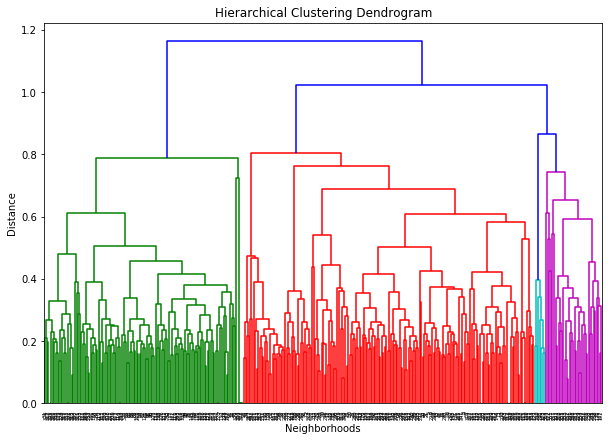

In [33]:
import scipy.cluster.hierarchy as hicls

data = allvenues_grouped.iloc[:,6:]
plt.figure(figsize=(10, 7))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=31, c='k')
dend = hicls.dendrogram(hicls.linkage(data, method='ward'))

According to the above graph, I decide to separate our neighborhoods into seven clusters (cut at distance of 0.75, horizontal black line). I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods.

In [34]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

In [35]:
#assign the cluster label to the data
allvenues_sorted['Cluster_Labels'] = clusterresult

In [36]:
# Define a function to show the neighborhoods with same cluster labels

def clustermap(cityname,countryname,dataframe):
    # create map
    address = cityname + ',' + countryname

    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    my_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Cluster_Labels
    colnum = 9
    x = np.arange(colnum)
    ys = [i+x+(i*x)**2 for i in range(colnum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map

    for lat, lon, neighborhood, borough, cluster_labels in zip(dataframe['Latitude'], 
                                                               dataframe['Longitude'], 
                                                               dataframe['NeighborhoodName'], 
                                                               dataframe['Borough'],
                                                               dataframe['Cluster_Labels']):
        cluster = cluster_labels 
        label = '{}, {},Cluster:{}'.format(neighborhood, borough,cluster_labels)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(my_map)
        
    return my_map

## 4. Results

## Total number of neighborhoods in each cluster

In [37]:
for i in range(7):
    num = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == i].shape[0]
    print('Total number of neighborhoods in cluster {} is {}'.format(i, num))

Total number of neighborhoods in cluster 0 is 36
Total number of neighborhoods in cluster 1 is 5
Total number of neighborhoods in cluster 2 is 141
Total number of neighborhoods in cluster 3 is 7
Total number of neighborhoods in cluster 4 is 26
Total number of neighborhoods in cluster 5 is 121
Total number of neighborhoods in cluster 6 is 17


## 5. Discussion

### Cluster 1 only has 5 neighborhoods and cluster 3 has only 7 neighborhoods. These two clusters probably just contain the outliers. So let's look at cluster 1 and 3 first.

In [41]:
cluster1 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 1] 
cluster1

,City,Borough,NeighborhoodName,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
327,Toronto,North York,Downsview,43.7493,-79.4622,Athletics & Sports,Coffee Shop,Swim School,Sandwich Place,Soccer Field,Sporting Goods Shop,French Restaurant,Gas Station,Middle Eastern Restaurant,Gym / Fitness Center,1
328,Toronto,North York,Downsview,43.7493,-79.4622,Athletics & Sports,Coffee Shop,Swim School,Sandwich Place,Soccer Field,Sporting Goods Shop,French Restaurant,Gas Station,Middle Eastern Restaurant,Gym / Fitness Center,1
329,Toronto,North York,Humber Summit,43.7601,-79.5718,Sports Bar,Mexican Restaurant,Coffee Shop,Filipino Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,1
330,Toronto,North York,Downsview,43.7493,-79.4622,Athletics & Sports,Coffee Shop,Swim School,Sandwich Place,Soccer Field,Sporting Goods Shop,French Restaurant,Gas Station,Middle Eastern Restaurant,Gym / Fitness Center,1
334,Toronto,North York,Downsview,43.7493,-79.4622,Athletics & Sports,Coffee Shop,Swim School,Sandwich Place,Soccer Field,Sporting Goods Shop,French Restaurant,Gas Station,Middle Eastern Restaurant,Gym / Fitness Center,1


### Cluster 1 is not an outlier, it's a neighborhood with the sports complex.

In [42]:
cluster3 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 3]
cluster3

,City,Borough,NeighborhoodName,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
85,New York,Brooklyn,Sea Gate,40.5764,-74.0079,Beach,Supermarket,Spa,Basketball Court,Chinese Restaurant,Park,Pharmacy,Donut Shop,Home Service,Pizza Place,3
178,New York,Queens,Rockaway Beach,40.5828,-73.8224,Beach,Bar,Beach Bar,Supermarket,Bagel Shop,Deli / Bodega,Eastern European Restaurant,Wine Bar,Pharmacy,Pizza Place,3
179,New York,Queens,Neponsit,40.572,-73.8575,Beach,Spa,Deli / Bodega,Pub,Harbor / Marina,Boutique,Bakery,Park,Chinese Restaurant,Bus Stop,3
190,New York,Queens,Belle Harbor,40.5762,-73.854,Beach,Spa,Pub,Mexican Restaurant,Smoke Shop,Bakery,Bagel Shop,Event Space,Pharmacy,Donut Shop,3
191,New York,Queens,Rockaway Park,40.5803,-73.8415,Beach,Pizza Place,Donut Shop,Pub,Bank,Bar,Bagel Shop,Spa,Pharmacy,Discount Store,3
204,New York,Staten Island,South Beach,40.5802,-74.0796,Beach,Pier,Food,Playground,Bus Stop,Athletics & Sports,American Restaurant,Baseball Field,Deli / Bodega,Soccer Field,3
302,New York,Queens,Hammels,40.5873,-73.8055,Beach,Surf Spot,Board Shop,Bar,Supermarket,Donut Shop,Wine Bar,Taco Place,Pizza Place,Coffee Shop,3


### Cluster 3 is not also an oulier, it's a neighborhood with beach as the most common venue 

In [43]:
cluster6 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 6]
cluster6

,City,Borough,NeighborhoodName,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
2,New York,Bronx,Eastchester,40.8876,-73.8278,Caribbean Restaurant,Shopping Mall,Fast Food Restaurant,Diner,Discount Store,Donut Shop,Mobile Phone Shop,Burger Joint,Supplement Shop,Asian Restaurant,6
54,New York,Brooklyn,Flatbush,40.6363,-73.9584,Caribbean Restaurant,Bar,Mexican Restaurant,Café,Coffee Shop,Juice Bar,Middle Eastern Restaurant,Health Food Store,Pizza Place,Farmers Market,6
56,New York,Brooklyn,East Flatbush,40.6417,-73.9361,Discount Store,Caribbean Restaurant,Supermarket,Hardware Store,Pharmacy,Liquor Store,Storage Facility,Mobile Phone Shop,Furniture / Home Store,Sandwich Place,6
74,New York,Brooklyn,Canarsie,40.6356,-73.9021,Caribbean Restaurant,Pizza Place,Video Game Store,Grocery Store,Pharmacy,Bank,Food,Cosmetics Shop,Chinese Restaurant,Gym,6
75,New York,Brooklyn,Flatlands,40.6304,-73.9291,Caribbean Restaurant,Supermarket,Mobile Phone Shop,Pharmacy,Discount Store,Lounge,Fried Chicken Joint,Fast Food Restaurant,Farmers Market,Donut Shop,6
88,New York,Brooklyn,Prospect Lefferts Gardens,40.6584,-73.9549,Caribbean Restaurant,Café,Bakery,Wine Shop,Cocktail Bar,Pizza Place,Liquor Store,Juice Bar,Sandwich Place,Park,6
93,New York,Brooklyn,Prospect Park South,40.647,-73.9626,Caribbean Restaurant,Pizza Place,Mexican Restaurant,Grocery Store,Bar,Coffee Shop,Park,Asian Restaurant,Latin American Restaurant,Gym / Fitness Center,6
165,New York,Queens,St. Albans,40.6944,-73.7587,Caribbean Restaurant,Pizza Place,Fried Chicken Joint,Discount Store,Fish & Chips Shop,Café,Chinese Restaurant,Bakery,Pharmacy,Donut Shop,6
168,New York,Queens,Cambria Heights,40.6928,-73.7353,Caribbean Restaurant,Pharmacy,Donut Shop,Cosmetics Shop,Pizza Place,Fried Chicken Joint,Bus Stop,Fast Food Restaurant,Gas Station,Playground,6
188,New York,Queens,Laurelton,40.6679,-73.7403,Caribbean Restaurant,Pharmacy,Park,Train Station,Donut Shop,Fried Chicken Joint,Discount Store,Grocery Store,Chinese Restaurant,Shipping Store,6


### Cluster 6 contains the neighborhoods in New York with a lot of nearby Caribbean restaurants, pizza places and fast food restaurants.

In [44]:
cluster4 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 4]
cluster4

,City,Borough,NeighborhoodName,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
16,New York,Bronx,Fordham,40.861,-73.8964,Italian Restaurant,Pizza Place,Diner,Dessert Shop,Liquor Store,Gym,Deli / Bodega,Shoe Store,Plaza,Spanish Restaurant,4
28,New York,Bronx,Throgs Neck,40.8151,-73.8164,Italian Restaurant,Deli / Bodega,Pizza Place,Donut Shop,Japanese Restaurant,Sports Bar,Tennis Court,Park,Beach,Chinese Restaurant,4
29,New York,Bronx,Country Club,40.8442,-73.8241,Sandwich Place,Italian Restaurant,Pizza Place,Bakery,Bank,Pharmacy,Deli / Bodega,Dive Bar,Donut Shop,BBQ Joint,4
34,New York,Bronx,Belmont,40.8573,-73.8885,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Food & Drink Shop,Liquor Store,Café,Plaza,Bar,4
36,New York,Bronx,North Riverdale,40.9085,-73.9045,Pizza Place,Sushi Restaurant,Pool,Italian Restaurant,Coffee Shop,Deli / Bodega,Diner,Burger Joint,Bank,Sandwich Place,4
37,New York,Bronx,Pelham Bay,40.8506,-73.8321,Italian Restaurant,Sandwich Place,Bakery,Bank,Donut Shop,Pharmacy,Dive Bar,Pizza Place,Convenience Store,Rental Car Location,4
38,New York,Bronx,Schuylerville,40.8266,-73.8262,Italian Restaurant,Pizza Place,American Restaurant,Diner,Donut Shop,Pharmacy,Mexican Restaurant,Bank,Sandwich Place,Bar,4
39,New York,Bronx,Edgewater Park,40.822,-73.8139,Italian Restaurant,Deli / Bodega,Pizza Place,Bar,Diner,Donut Shop,Hookah Bar,Coffee Shop,Harbor / Marina,Sandwich Place,4
94,New York,Brooklyn,Georgetown,40.6238,-73.9161,Bank,Italian Restaurant,Pizza Place,Bagel Shop,Mobile Phone Shop,Deli / Bodega,Japanese Restaurant,Supermarket,American Restaurant,Donut Shop,4
133,New York,Queens,Howard Beach,40.6542,-73.8381,Italian Restaurant,Pharmacy,Ice Cream Shop,Sushi Restaurant,Bagel Shop,Fast Food Restaurant,Sandwich Place,Bank,Pizza Place,Gym / Fitness Center,4


### Cluster 4 contains the neighborhoods in New York with a lot of nearby Italian restaurants and pizza places.

In [45]:
cluster0 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 0]
cluster0

,City,Borough,NeighborhoodName,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
22,New York,Bronx,Port Morris,40.8017,-73.9132,Baseball Field,Donut Shop,Cupcake Shop,Pizza Place,Grocery Store,Restaurant,Discount Store,Burger Joint,Deli / Bodega,Metro Station,0
78,New York,Brooklyn,Coney Island,40.5743,-73.9887,Theme Park Ride / Attraction,Beach,Hot Dog Joint,Baseball Stadium,Caribbean Restaurant,Ice Cream Shop,Pizza Place,Arcade,Theme Park,Sporting Goods Shop,0
167,New York,Queens,Springfield Gardens,40.6662,-73.7604,Deli / Bodega,Gym,Check Cashing Service,Intersection,Park,Fried Chicken Joint,Caribbean Restaurant,Pizza Place,Donut Shop,Bakery,0
171,New York,Queens,Broad Channel,40.603,-73.8201,Chinese Restaurant,Business Service,Surf Spot,Bagel Shop,Beach,Other Nightlife,Dive Bar,Metro Station,Sandwich Place,Playground,0
172,New York,Queens,Breezy Point,40.5574,-73.9255,Surf Spot,Park,American Restaurant,Beach,Trail,Field,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,0
177,New York,Queens,Arverne,40.5891,-73.792,Surf Spot,Beach,Sandwich Place,Deli / Bodega,Donut Shop,Bus Stop,Pizza Place,Gym / Fitness Center,Bank,Bed & Breakfast,0
192,New York,Queens,Somerville,40.5977,-73.7966,Sandwich Place,Donut Shop,Taco Place,Gym / Fitness Center,Bed & Breakfast,Metro Station,Bank,Caribbean Restaurant,Thai Restaurant,Coffee Shop,0
193,New York,Queens,Brookville,40.66,-73.7518,Park,Intersection,Deli / Bodega,Fried Chicken Joint,Sandwich Place,Bus Stop,Sporting Goods Shop,Fast Food Restaurant,Caribbean Restaurant,Gym,0
199,New York,Staten Island,Stapleton,40.6269,-74.0779,Sandwich Place,Bus Stop,Mexican Restaurant,Pizza Place,Discount Store,Bank,Fast Food Restaurant,Bar,Coffee Shop,Pharmacy,0
200,New York,Staten Island,Rosebank,40.6153,-74.0698,Bus Stop,Italian Restaurant,Bar,Beach,Intersection,Mexican Restaurant,Grocery Store,Pizza Place,Filipino Restaurant,Gastropub,0


### Cluster 0 contains the neighborhoods a lot of recreation activities like theme park, baseball field, park, surf spot, ferry, zoo, campground and many.

In [48]:
cluster5 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 5]
cluster5.head(10)

,City,Borough,NeighborhoodName,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
7,New York,Bronx,Woodlawn,40.8983,-73.8673,Pub,Deli / Bodega,Bar,Pizza Place,Bank,Discount Store,Donut Shop,Baseball Field,Italian Restaurant,Pharmacy,5
12,New York,Bronx,City Island,40.8472,-73.7865,Harbor / Marina,Seafood Restaurant,Italian Restaurant,Park,American Restaurant,Bar,Boat or Ferry,Spanish Restaurant,Thrift / Vintage Store,Smoke Shop,5
19,New York,Bronx,High Bridge,40.8366,-73.9261,Lounge,Baseball Stadium,Historic Site,Plaza,Gift Shop,Gas Station,Caribbean Restaurant,Liquor Store,BBQ Joint,Track Stadium,5
24,New York,Bronx,Hunts Point,40.8097,-73.8833,Seafood Restaurant,Park,Spanish Restaurant,Travel & Transport,BBQ Joint,Market,Bakery,Chinese Restaurant,Gym / Fitness Center,Bank,5
46,New York,Brooklyn,Bay Ridge,40.6258,-74.0306,Pizza Place,Spa,Greek Restaurant,Hookah Bar,Grocery Store,Chinese Restaurant,American Restaurant,Cosmetics Shop,Bakery,Breakfast Spot,5
47,New York,Brooklyn,Bensonhurst,40.611,-73.9952,Bakery,Italian Restaurant,Bagel Shop,Chinese Restaurant,Japanese Restaurant,Pizza Place,Supplement Shop,Liquor Store,Coffee Shop,Cantonese Restaurant,5
48,New York,Brooklyn,Sunset Park,40.6451,-74.0103,Bakery,Mexican Restaurant,Latin American Restaurant,Pizza Place,Café,Bank,Chinese Restaurant,Spanish Restaurant,Cocktail Bar,Park,5
49,New York,Brooklyn,Greenpoint,40.7302,-73.9542,Coffee Shop,Cocktail Bar,Yoga Studio,Pizza Place,Bakery,Bar,Café,Furniture / Home Store,Sushi Restaurant,Grocery Store,5
51,New York,Brooklyn,Brighton Beach,40.5768,-73.9651,Sushi Restaurant,Grocery Store,Supermarket,Neighborhood,Russian Restaurant,Beach,Aquarium,Restaurant,Mediterranean Restaurant,Bakery,5
52,New York,Brooklyn,Sheepshead Bay,40.5869,-73.9432,Turkish Restaurant,Italian Restaurant,Sandwich Place,Pizza Place,Dessert Shop,Sushi Restaurant,Russian Restaurant,Seafood Restaurant,Burger Joint,Café,5


In [49]:
cluster5.tail(10)

,City,Borough,NeighborhoodName,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
335,Toronto,Central Toronto,Lawrence Park,43.7292,-79.4033,Sushi Restaurant,Bakery,Italian Restaurant,Coffee Shop,Pub,Bank,Sandwich Place,Fast Food Restaurant,Asian Restaurant,Shoe Store,5
338,Toronto,North York,York Mills West,43.744,-79.4067,Coffee Shop,Restaurant,Park,Gym,Pub,French Restaurant,Thai Restaurant,Grocery Store,Gym / Fitness Center,Sandwich Place,5
339,Toronto,Central Toronto,Davisville North,43.6979,-79.3973,Sushi Restaurant,Italian Restaurant,Coffee Shop,Restaurant,Indian Restaurant,Park,Gaming Cafe,Syrian Restaurant,Gastropub,General Entertainment,5
340,Toronto,Central Toronto,Forest Hill North & West,43.701,-79.4256,Coffee Shop,Sushi Restaurant,Pizza Place,Italian Restaurant,Trail,Skating Rink,Dry Cleaner,Bagel Shop,Bakery,Park,5
342,Toronto,North York,Willowdale,43.7615,-79.4109,Coffee Shop,Grocery Store,Japanese Restaurant,Fried Chicken Joint,Ramen Restaurant,Burger Joint,Café,Lounge,Movie Theater,Fast Food Restaurant,5
343,Toronto,West Toronto,Parkdale / Roncesvalles,43.6399,-79.4397,Bakery,Tibetan Restaurant,Park,Indian Restaurant,Café,Gift Shop,Diner,Restaurant,Eastern European Restaurant,Tea Room,5
345,Toronto,Central Toronto,Davisville,43.6979,-79.3973,Sushi Restaurant,Italian Restaurant,Coffee Shop,Restaurant,Indian Restaurant,Park,Gaming Cafe,Syrian Restaurant,Gastropub,General Entertainment,5
346,Toronto,West Toronto,Runnymede / Swansea,43.6518,-79.4759,Coffee Shop,Café,Pub,Italian Restaurant,Bakery,Bank,Sushi Restaurant,Falafel Restaurant,Gourmet Shop,Burrito Place,5
350,Toronto,Etobicoke,Northwest,43.6715,-79.5525,Liquor Store,Coffee Shop,Café,Pharmacy,Grocery Store,Pet Store,Sushi Restaurant,Supermarket,Bank,Event Service,5
352,Toronto,Downtown Toronto,Church and Wellesley,43.6612,-79.3821,Coffee Shop,Japanese Restaurant,Gastropub,Park,Plaza,Mexican Restaurant,Salon / Barbershop,Sandwich Place,Theme Restaurant,Theater,5


### Cluster 5 contains the neighborhoods with a lot of Bar, Pub, Lounge, japanese restaurant and sushi places.

In [51]:
#cluster2 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 2]
cluster2.head(10)

,City,Borough,NeighborhoodName,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
0,New York,Bronx,Wakefield,40.8947,-73.8472,Pharmacy,Supermarket,Caribbean Restaurant,Donut Shop,Gas Station,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Deli / Bodega,Bank,2
1,New York,Bronx,Co-op City,40.8743,-73.8299,Shopping Mall,Kids Store,Mattress Store,Mexican Restaurant,Mobile Phone Shop,Furniture / Home Store,Supermarket,Fast Food Restaurant,Caribbean Restaurant,Shoe Store,2
3,New York,Bronx,Fieldston,40.8954,-73.9056,Pizza Place,Bus Station,Bar,Sandwich Place,Bank,Plaza,Deli / Bodega,Park,Mexican Restaurant,Greek Restaurant,2
4,New York,Bronx,Riverdale,40.8908,-73.9126,Pizza Place,Bank,Bar,Park,Plaza,Playground,Dog Run,Bagel Shop,Coffee Shop,Health & Beauty Service,2
5,New York,Bronx,Kingsbridge,40.8817,-73.9028,Pizza Place,Mexican Restaurant,Donut Shop,Bar,Burger Joint,Bakery,Spanish Restaurant,Japanese Restaurant,Diner,Coffee Shop,2
6,New York,Manhattan,Marble Hill,40.8766,-73.9107,Mexican Restaurant,Sandwich Place,Café,Pizza Place,Spanish Restaurant,Coffee Shop,Donut Shop,Park,Gym,Scenic Lookout,2
8,New York,Bronx,Norwood,40.8772,-73.8794,Pizza Place,Bank,Pharmacy,Park,Sandwich Place,Caribbean Restaurant,Mexican Restaurant,Donut Shop,Spanish Restaurant,Fast Food Restaurant,2
9,New York,Bronx,Williamsbridge,40.881,-73.8574,Caribbean Restaurant,Pizza Place,Fried Chicken Joint,Sandwich Place,Shoe Store,Bakery,Spa,Pharmacy,Cosmetics Shop,Fast Food Restaurant,2
10,New York,Bronx,Baychester,40.8669,-73.8358,Shopping Mall,Clothing Store,Discount Store,Spanish Restaurant,Bakery,Pharmacy,Supermarket,Furniture / Home Store,Kids Store,Pizza Place,2
11,New York,Bronx,Pelham Parkway,40.8574,-73.8548,Pizza Place,Donut Shop,Bakery,Bank,Italian Restaurant,Sandwich Place,Burger Joint,Gas Station,Supermarket,Cosmetics Shop,2


In [52]:
cluster2.tail(10)

,City,Borough,NeighborhoodName,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
322,Toronto,East York,Thorncliffe Park,43.7046,-79.3454,Indian Restaurant,Afghan Restaurant,Bank,Coffee Shop,Turkish Restaurant,Fried Chicken Joint,Pizza Place,Supermarket,Brewery,Burger Joint,2
324,Toronto,Scarborough,Scarborough Village,43.7437,-79.2116,Coffee Shop,Fast Food Restaurant,Grocery Store,Chinese Restaurant,Pizza Place,Fried Chicken Joint,Bus Line,Butcher,Big Box Store,Beer Store,2
326,Toronto,North York,Bayview Village,43.7692,-79.3767,Coffee Shop,Furniture / Home Store,Bank,Café,Chinese Restaurant,Burger Joint,Clothing Store,Sandwich Place,Bakery,Toy / Game Store,2
336,Toronto,Central Toronto,Roselawn,43.6995,-79.4546,Furniture / Home Store,Coffee Shop,Park,Bank,Sandwich Place,Pizza Place,Bakery,Pharmacy,Fast Food Restaurant,Bike Shop,2
337,Toronto,York,Weston,43.7002,-79.5162,Park,Train Station,Coffee Shop,Breakfast Spot,Laundromat,Skating Rink,Bank,Soccer Field,Pharmacy,Café,2
341,Toronto,Etobicoke,Westmount,43.6936,-79.521,Pizza Place,Park,Bank,Train Station,Gas Station,Convenience Store,Laundromat,Chinese Restaurant,Soccer Field,Gift Shop,2
344,Toronto,Scarborough,Agincourt,43.7854,-79.2785,Chinese Restaurant,Vietnamese Restaurant,Shopping Mall,Cantonese Restaurant,Restaurant,Korean Restaurant,Café,Liquor Store,Asian Restaurant,Beer Store,2
347,Toronto,Scarborough,Steeles West / L'Amoreaux West,43.7982,-79.318,Chinese Restaurant,Pizza Place,Grocery Store,Bank,Bakery,Coffee Shop,Fast Food Restaurant,Breakfast Spot,Shopping Mall,Gym Pool,2
348,Toronto,Downtown Toronto,Rosedale,43.6563,-79.3809,Furniture / Home Store,Caribbean Restaurant,Coffee Shop,Sandwich Place,Fast Food Restaurant,Cosmetics Shop,Japanese Restaurant,Restaurant,Theater,Park,2
349,Toronto,Etobicoke,Alderwood / Long Branch,43.6017,-79.5452,Discount Store,Pharmacy,Convenience Store,Pizza Place,Coffee Shop,Sandwich Place,Park,Intersection,Grocery Store,Gym,2


### Cluster 2 contains the neighborhoods in Malls, Supermarkets, Pharmacy, furniture and stores.

# Explore the neighborhoods with similar clusters using map

### Cluster 0 - Neighborhoods with Recreational places in New York

In [53]:
clustermap('New York','USA',cluster0)

### Cluster 0 - Neighborhoods with Recreational places in Toronto

In [54]:
clustermap('Toronto','Canada',cluster0)

### Cluster2 - Neighborhood with Suprmarkets, Malls, Pharmacies, Furniture and other stores

In [55]:
clustermap('New York','USA',cluster2[cluster2['City'] == 'New York'])

In [56]:
clustermap('Toronto','Canada',cluster2[cluster2['City'] == 'Toronto'])

## 6. Conclusion

### With all the analysis we have done, we can conclude that,
### Cluster 0 - Neighborhood with all type of Recreational centers
### Cluster 1 - Neighborhood with Sports Complex 
### Cluster 2 - Neighborhood with Super markets, malls - (Residential) 
### Cluster 3 - Neighborhood with Beach 
### Cluster 4 - Neighborhood with more no. of Italian restaurants
### Cluster 5 - Neighborhood with Pub, Bar and Sushi places
### Cluster 6 - Neighborhood with more no.of Caribbean restaurants